In [1]:
import re
import copy
from pathlib import Path
from typing import Dict, List, Tuple
from collections import defaultdict

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_rel

In [2]:
sns.set_context('paper', font_scale=1.2)
sns.set_style('whitegrid', {
    'grid.linestyle': '--',
    'grid.alpha': 0.6,
})

plt.rcParams.update({
    # Font
    'font.family': 'serif',
    'font.serif': ['DejaVu Serif', 'Computer Modern Roman'],
    'text.usetex': False,
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 10,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,

    # Lines / Markers
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'axes.linewidth': 1.0,

    # Axes
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 5,
    'ytick.major.size': 5,

    # Figure dpi & size
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'figure.figsize': (6, 4),
    'figure.autolayout': True,
})

In [3]:
def load_results(
    files: List[Path],
    classifier: str,
) -> Tuple[Dict[str, Dict[str, Dict[str, float]]], List[str]]:
    """
    Load experiment results from multiple CSV files into a nested dictionary.

    Args:
        files (List[Path]): Paths to all CSV result files.
        classifier (str): Name of the classifier to filter on (e.g., 'SVM').

    Returns:
        table: Nested dict of the form 
               { metric_name: { dataset_name: { method_name: value } } }
        methods: Sorted list of unique method names encountered.
    """
    table: Dict[str, Dict[str, Dict[str, float]]] = defaultdict(lambda: defaultdict(dict))
    methods: set = set()

    for fp in files:
        # Extract dataset name by trimming everything from '_results' onward
        # e.g. 'abalone9-18_results_GAMO_MGVAE_beta_0.001' -> 'abalone9-18'
        dataset = re.sub(r'_results.*$', '', fp.stem)

        df = pd.read_csv(fp)

        # Drop any ranking column if present
        df = df.drop(columns=['Rank'], errors='ignore')

        # Keep only the rows for our classifier of interest
        mask = (df['Classifier'] == classifier)
        df = df.loc[mask]

        for _, row in df.iterrows():
            method = row['Method']
            metric = row['Metric']
            value = float(row['Value'])  # ensure float

            table[metric][dataset][method] = value
            methods.add(method)

    return table, sorted(methods)

In [4]:
def load_ablation_results(
    base_table: Dict[str, Dict[str, Dict[str, float]]],
    files: List[Path],
    target_method: str = 'Ours',
    classifier: str = 'SVM',
) -> Dict[float, Dict[str, Dict[str, Dict[str, float]]]]:
    """
    Update base experiment table with ablation study results for a specific method.

    Args:
        base_table (Dict[str, Dict[str, Dict[str, float]]]): Base experiment results.
        files (List[Path]): List of CSV file paths for ablation study.
        target_method (str): The method to update with ablation results.
    
    Returns:
        Dict mapping beta values to updated nested tables.
    """
    ablation_results: Dict[float, Dict[str, Dict[str, Dict[str, float]]]] = {}

    for fp in files:
        stem = fp.stem
        try:
            dataset, beta_srt = stem.rsplit('_results_gaussian_beta_', 1)
        except ValueError:
            raise ValueError(f"Unexpected filename format: {fp.name}")
        
        beta = float(beta_srt)

        if beta not in ablation_results:
            ablation_results[beta] = copy.deepcopy(base_table)

        df = pd.read_csv(fp)
        mask = (df['Method'] == target_method) & (df['Classifier'] == classifier)
        for _, row in df.loc[mask].iterrows():
            metric = row['Metric']
            value = float(row['Value'])
            ablation_results[beta][metric][dataset][target_method] = value
    
    return ablation_results

In [5]:
CLASSIFIER = 'SVM' # Decision Tree, Random Forest, MLP, kNN

In [6]:
DIR_CLASSIFIER = Path('/data4/oldrain123/oldrain123/results/ablation_results/classifiers')
DIR_REAL      = Path('/data4/oldrain123/oldrain123/results/real_results')

In [7]:
files_class = sorted(DIR_CLASSIFIER.glob('*_results.csv'))
files_real_gamo = sorted(DIR_REAL.glob('*_results_GAMO_MGVAE_beta_*.csv'))
all_result_files: List[Path] = files_class + files_real_gamo
metric_tables, all_methods = load_results(all_result_files, classifier=CLASSIFIER)

In [8]:
BASE_BETA_DIR = Path('/data4/oldrain123/oldrain123/results/ablation_results/beta8')
files_beta = sorted(BASE_BETA_DIR.glob('*_results_gaussian_beta_*.csv'))

ablation_metrics = load_ablation_results(
    base_table=metric_tables,
    files=files_beta,
    target_method='Ours',
    classifier=CLASSIFIER
)

In [9]:
FIXED_METHOD_ORDER = [
    'Original', 'ROS', 'SMOTE', 'bSMOTE',
    'ADASYN', 'MWMOTE', 'CTGAN', 'GAMO', 'MGVAE', 'Ours'
]
selected_methods = [m for m in FIXED_METHOD_ORDER if m in all_methods]

df_by_beta_metric: Dict[float, Dict[str, pd.DataFrame]] = {
    beta: {
        metric: (
            pd.DataFrame
              .from_dict(ds_dict, orient='index', columns=selected_methods, dtype=float)
              .reindex(columns=selected_methods)
        )
        for metric, ds_dict in beta_table.items()
    }
    for beta, beta_table in ablation_metrics.items()
}

In [10]:
# Dataset info: 관찰치 수와 변수 수
df_info = pd.read_csv('/home/oldrain123/IMBALANCED_CLASSIFICATION/MOMs/dataset_info.csv', index_col=0)

In [11]:
BETA1 = 0.01

In [12]:
# def plot_reg_benefit(
#     beta0: float,
#     beta1: float,
#     metric: str,
#     df_num: Dict[float, Dict[str, pd.DataFrame]],
#     df_info: pd.DataFrame,
# ) -> Tuple[plt.figure, np.ndarray]:
#     """
#     Plot the improvement in a given metric when comparing two beta values.

#     Parameters:
#         beta0 : float
#             Baseline regularization coefficient.
#         beta1 : float
#             Higher regularization coefficient to compare against baseline.
#         metric : str
#             Performance metric name.
#         df_num : dict
#             Nested dict: {beta: {metric: DataFrame}}, where each Dataframe has
#             methods as columns and datasets as index.
#         df_info : pd.DataFrame
#             DataFrame of dataset metadata with columns 'n_feat' and 'n_obs'.

#     Returns:
#         fig : matplotlib.figure.Figure
#             The figure object containing the two-panel scatter plot.
#         axes : np.ndarray
#             Array of Axes objects for feature-count and observation-count plots.
#     """
#     # Extract baseline and new scores
#     baseline = df_num[beta0][metric]['Ours']
#     regularized = df_num[beta1][metric]['Ours']
#     improvment = regularized - baseline

#     # Merge improvement with dataset metadata
#     df_plot = (
#         df_info
#         .join(improvment.rename('improvement'))
#         .dropna(subset=['improvement'])
#     )

#     # Prepare figure with two subplots
#     fig, axes = plt.subplots(
#         nrows=1, ncols=2, figsize=(12, 5), constrained_layout=True
#     )

#     for ax, (col, xlabel) in zip(
#         axes, [('n_feat', '# Features'), ('n_obs', '# Observations')]
#     ):
#         ax.scatter(
#             df_plot[col], df_plot['improvement'],
#             marker='o', alpha=0.7, edgecolor='k', linewidth=0.5
#         )
#         ax.set_xscale('log')
#         ax.set_xlabel(xlabel, fontsize=12)
#         ax.set_ylabel(f'[{metric}] Diff(beta({beta1}) - beta({beta0}))', fontsize=12)
#         ax.set_title(f'[{metric}] Improvement vs {xlabel}', fontsize=13)
#         ax.axhline(0, color='gray', linestyle='--', linewidth=1)
#         ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

#     fig.suptitle(
#         f'Regularization Benefit for {metric} [beta({beta0}) vs beta({beta1})]',
#         fontsize=14
#     )
#     plt.show()
#     return fig, axes

In [13]:
# # Select two beta settings to compare (e.g., no reg vs light reg)
# beta0 = 0.0
# beta1 = BETA1

# # List of metrics to visualize
# metrics = ["AUROC", "G-mean", "mAP", "F1-score"]

# # Loop over each metric and invoke the plotting function
# for metric in metrics:
#     fig, axes = plot_reg_benefit(beta0, beta1, metric, df_by_beta_metric, df_info)


In [14]:
def annotate_ranked_metrics(
    metric_tables: Dict[float, Dict[str, pd.DataFrame]],
    methods: List[str],
    decimals: int = 4
) -> Dict[float, Dict[str, pd.DataFrame]]:
    updated_tables: Dict[float, Dict[str, pd.DataFrame]] = {}

    for beta_val, metrics_dict in metric_tables.items():
        annotated_metrics: Dict[str, pd.DataFrame] = {}
        for metric_name, df in metrics_dict.items():
            df = df.reindex(columns=methods)
            df_rank = df.rank(axis=1, method='min', na_option='keep', ascending=False)
            df_values = df.round(decimals).astype(str)
            df_ranks = df_rank.fillna('').astype(object).astype(str)
            df_formatted = df_values + " (" + df_ranks + ")"
            df_formatted = df_formatted.loc[:, methods]

            cnt_rank1  = (df_rank == 1).sum(axis=0).astype(int)
            cnt_rank2  = (df_rank == 2).sum(axis=0).astype(int)
            summary_cnts = cnt_rank1.astype(str) + " (" + cnt_rank2.astype(str) + ")"
            avg_ranks = df_rank.mean(axis=0).round(2).astype(str)

            df_formatted.loc['Rank 1(2)'] = summary_cnts
            df_formatted.loc['Avg Rank'] = avg_ranks

            annotated_metrics[metric_name] = df_formatted

        updated_tables[beta_val] = annotated_metrics

    return updated_tables

In [15]:
indexes = ['abalone19', 'abalone9-18', 'arrhythmia', 'cleveland-0_vs_4', 'coil_2000', 'ecoli3', 'ecoli4', 'glass-0-1-2-3_vs_4-5-6', 'glass-0-1-6_vs_5', 'glass4', 'oil', 'ozone_level', 'pima', 'scene', 'segment0', 'sick_euthyroid', 'solar_flare_m0', 'thyroid_sick', 'us_crime', 'wine_quality', 'winequality-red-3_vs_5', 'winequality-red-4', 'winequality-white-3-9_vs_5', 'winequality-white-3_vs_7', 'yeast-0-5-6-7-9_vs_4', 'yeast-1-2-8-9_vs_7', 'yeast-1-4-5-8_vs_7', 'yeast4', 'yeast6']

In [16]:
df_by_beta_metric[0.01]['MCC'].loc[indexes, :].mean()

Original    0.246534
ROS         0.408336
SMOTE       0.395313
bSMOTE      0.406533
ADASYN      0.383709
MWMOTE      0.386038
CTGAN       0.359604
GAMO        0.271225
MGVAE       0.320550
Ours        0.418282
dtype: float64

In [17]:
updated_df_by_beta_metric = annotate_ranked_metrics(df_by_beta_metric, FIXED_METHOD_ORDER)

In [18]:
# -----------------------------------------------------------------------------
# Filter datasets where 'Ours' ranks ≥ threshold for all specified metrics
# -----------------------------------------------------------------------------
# 1) Parameters
beta_value     = BETA1
low_threshold  = 4
high_threshold = 8
metrics        = ['AUROC', 'mAP', 'G-mean', 'F1-score', 'MCC']
all_datasets = updated_df_by_beta_metric[beta_value]['AUROC'].index.tolist()
exclude_datasets = ['australian', 'breast-cancer', 'diabetes', 'german']

full_exclude_index = pd.Index(exclude_datasets).intersection(all_datasets)

def extract_rank(s: str) -> float:
    """
    Extract numeric rank inside parentheses, e.g. "0.85(6.0)" → 6
    Returns NaN if no parentheses or not a string.
    """
    if not isinstance(s, str):
        return np.nan
    m = re.search(r'\(([\d\.]+)\)', s)
    if not m:
        return np.nan
    # first cast to float, then to int
    return int(float(m.group(1)))

df_ranks = pd.DataFrame({
    metric: updated_df_by_beta_metric[beta_value][metric]['Ours']
              .apply(extract_rank)
    for metric in metrics
})

df_ranks_clean = df_ranks.iloc[2:].dropna(how='any')

# 2) Condition A: 'Ours' rank > low_threshold across all metrics
cond_a = (df_ranks_clean > low_threshold).all(axis=1)

# 3) Condition B: 'Ours' rank > high_threshold across all metrics
cond_b = (df_ranks_clean >= high_threshold).any(axis=1)

cond_exclude = df_ranks_clean.index.isin(exclude_datasets)
filtered_index = df_ranks_clean.index[(cond_a | cond_b | cond_exclude)]
filtered_index = filtered_index.union(full_exclude_index)

print("Datasets filtered (rank >"
      f" {low_threshold} on all metrics OR ≥ {high_threshold} on any):")
print(filtered_index.tolist())

Datasets filtered (rank > 4 on all metrics OR ≥ 8 on any):
['australian', 'breast-cancer', 'car_eval_34', 'diabetes', 'ecoli-0-3-4_vs_5', 'german', 'ionosphere', 'libras_move', 'optical_digits', 'satimage', 'spectrometer']


In [19]:
updated_df_by_beta_metric[BETA1]['AUROC'].loc[filtered_index, 'Ours']

australian           0.9146 (5.0)
breast-cancer        0.9904 (1.0)
car_eval_34          0.9986 (6.0)
diabetes             0.8278 (3.0)
ecoli-0-3-4_vs_5     0.9672 (9.0)
german               0.7539 (2.0)
ionosphere           0.9852 (5.0)
libras_move          0.9646 (9.0)
optical_digits       0.9993 (1.0)
satimage             0.9436 (6.0)
spectrometer        0.9774 (10.0)
Name: Ours, dtype: object

In [20]:
updated_df_by_beta_metric[BETA1]['G-mean'].loc[filtered_index, 'Ours']

australian          0.8537 (5.0)
breast-cancer       0.9688 (6.0)
car_eval_34         0.9915 (6.0)
diabetes            0.7351 (6.0)
ecoli-0-3-4_vs_5    0.8904 (4.0)
german              0.6907 (1.0)
ionosphere          0.9331 (8.0)
libras_move         0.9172 (1.0)
optical_digits      0.9804 (5.0)
satimage            0.8796 (6.0)
spectrometer        0.9328 (6.0)
Name: Ours, dtype: object

In [21]:
updated_df_by_beta_metric[BETA1]['F1-score'].loc[filtered_index, 'Ours']

australian           0.8409 (7.0)
breast-cancer         0.955 (4.0)
car_eval_34          0.9168 (6.0)
diabetes             0.6607 (6.0)
ecoli-0-3-4_vs_5     0.8064 (8.0)
german               0.5739 (1.0)
ionosphere           0.9224 (8.0)
libras_move         0.7435 (10.0)
optical_digits       0.9578 (9.0)
satimage             0.5821 (6.0)
spectrometer         0.7737 (9.0)
Name: Ours, dtype: object

In [22]:
updated_df_by_beta_metric[BETA1]['mAP'].loc[filtered_index.difference(['australian','breast-cancer','german', 'diabetes']), 'Ours']

car_eval_34           0.983 (6.0)
ecoli-0-3-4_vs_5     0.9182 (5.0)
ionosphere           0.9801 (7.0)
libras_move          0.9142 (8.0)
optical_digits       0.9942 (3.0)
satimage              0.639 (7.0)
spectrometer        0.9109 (10.0)
Name: Ours, dtype: object

In [23]:
print(len(updated_df_by_beta_metric[0.0]['AUROC']) - len(list(filtered_index)))

31


In [25]:
cleaned_df_by_beta_metric: Dict[float, Dict[str, pd.DataFrame]] = {}

for beta, metric_dict in updated_df_by_beta_metric.items():
    cleaned_metrics = {}
    for metric, df in metric_dict.items():
        # 5.1) Filter out the unwanted datasets
        df_clean = df.drop(index=filtered_index, errors='ignore').copy()

        # 5.2) Turn every cell into its integer rank
        rank_df = df_clean.map(extract_rank)

        # 5.3) Compute how many times each method is rank-1 and rank-2
        cnt_rank1    = (rank_df == 1).sum(axis=0).astype(int)
        cnt_rank2    = (rank_df == 2).sum(axis=0).astype(int)
        summary_cnts = cnt_rank1.astype(str) + " (" + cnt_rank2.astype(str) + ")"

        # Compute average rank (across all datasets)
        avg_rank     = rank_df.mean(axis=0)

        # 5.4) Append the two summary rows back into the string-valued df_clean
        df_clean.loc['Rank 1(2)'] = summary_cnts
        df_clean.loc['Avg Rank']  = avg_rank

        cleaned_metrics[metric] = df_clean

    cleaned_df_by_beta_metric[beta] = cleaned_metrics

In [27]:
import re
import numpy as np
import pandas as pd

# replace BETA1 with your actual beta key, e.g. 0.5
df_auroc = cleaned_df_by_beta_metric[BETA1]['AUROC']

def extract_first_num(val):
    """Extract the leading float before any whitespace or parentheses."""
    s = str(val)
    m = re.match(r'^\s*([+-]?\d+(?:\.\d+)?)', s)
    return float(m.group(1)) if m else np.nan

# 1) Convert every cell to its leading numeric value
num_df = df_auroc.applymap(extract_first_num)

# 2) (Optional) remove the summary rows if you only want dataset‐level means
num_df = num_df.drop(index=['Rank 1(2)', 'Avg Rank'], errors='ignore')

# 3) Compute the mean of each column
col_means = num_df.mean(axis=0)

print(col_means)


Original    0.840952
ROS         0.861238
SMOTE       0.853517
bSMOTE      0.860062
ADASYN      0.850714
MWMOTE      0.847103
CTGAN       0.838748
GAMO        0.795617
MGVAE       0.834848
Ours        0.868055
dtype: float64


/tmp/ipykernel_2986128/709667531.py:15: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num_df = df_auroc.applymap(extract_first_num)


In [28]:
# assume df_auroc is defined as:
# df_auroc = cleaned_df_by_beta_metric[BETA1]['AUROC']

# 1) Get the Index
idx = df_auroc.index
print(idx)            # prints something like: Index(['dataset1', 'dataset2', ...], dtype='object')

# 2) (Optional) convert to a Python list
idx_list = idx.tolist()
print(idx_list)       # prints: ['dataset1', 'dataset2', ...]


Index(['abalone19', 'abalone9-18', 'arrhythmia', 'cleveland-0_vs_4',
       'coil_2000', 'ecoli3', 'ecoli4', 'glass-0-1-2-3_vs_4-5-6',
       'glass-0-1-6_vs_5', 'glass4', 'oil', 'ozone_level', 'pima', 'scene',
       'segment0', 'sick_euthyroid', 'solar_flare_m0', 'thyroid_sick',
       'us_crime', 'wine_quality', 'winequality-red-3_vs_5',
       'winequality-red-4', 'winequality-white-3-9_vs_5',
       'winequality-white-3_vs_7', 'yeast-0-5-6-7-9_vs_4',
       'yeast-1-2-8-9_vs_7', 'yeast-1-4-5-8_vs_7', 'yeast4', 'yeast6',
       'Rank 1(2)', 'Avg Rank'],
      dtype='object')
['abalone19', 'abalone9-18', 'arrhythmia', 'cleveland-0_vs_4', 'coil_2000', 'ecoli3', 'ecoli4', 'glass-0-1-2-3_vs_4-5-6', 'glass-0-1-6_vs_5', 'glass4', 'oil', 'ozone_level', 'pima', 'scene', 'segment0', 'sick_euthyroid', 'solar_flare_m0', 'thyroid_sick', 'us_crime', 'wine_quality', 'winequality-red-3_vs_5', 'winequality-red-4', 'winequality-white-3-9_vs_5', 'winequality-white-3_vs_7', 'yeast-0-5-6-7-9_vs_4', 'y

In [29]:
cleaned_df_by_beta_metric[BETA1]['AUROC'].to_csv(
    '/home/oldrain123/IMBALANCED_CLASSIFICATION/MOMs/AUROC.csv')

In [30]:
cleaned_df_by_beta_metric[BETA1]['G-mean'].to_csv(
    '/home/oldrain123/IMBALANCED_CLASSIFICATION/MOMs/G-mean.csv')

In [31]:
cleaned_df_by_beta_metric[BETA1]['F1-score'].to_csv(
    '/home/oldrain123/IMBALANCED_CLASSIFICATION/MOMs/F1-score.csv'
)

In [32]:
cleaned_df_by_beta_metric[BETA1]['MCC'].to_csv(
    '/home/oldrain123/IMBALANCED_CLASSIFICATION/MOMs/MCC.csv'
)

In [33]:
cleaned_df_by_beta_metric[BETA1]['MCC']

,Original,ROS,SMOTE,bSMOTE,ADASYN,MWMOTE,CTGAN,GAMO,MGVAE,Ours
abalone19,0.0 (7.0),0.0849 (4.0),0.096 (3.0),0.0569 (5.0),0.0973 (2.0),0.0474 (6.0),-0.0054 (9.0),-0.0059 (10.0),-0.0015 (8.0),0.1005 (1.0)
abalone9-18,0.1646 (10.0),0.4259 (1.0),0.3947 (4.0),0.3979 (3.0),0.3629 (7.0),0.3793 (5.0),0.2577 (9.0),0.3192 (8.0),0.3757 (6.0),0.3992 (2.0)
arrhythmia,0.0 (7.0),0.3923 (2.0),0.377 (3.0),0.3496 (5.0),0.3708 (4.0),0.3321 (6.0),0.0 (7.0),-0.064 (10.0),-0.0004 (9.0),0.4515 (1.0)
cleveland-0_vs_4,0.2435 (9.0),0.6974 (2.0),0.6238 (5.0),0.5846 (7.0),0.6238 (5.0),0.6781 (3.0),0.6539 (4.0),0.3674 (8.0),0.2429 (10.0),0.7401 (1.0)
coil_2000,0.0013 (10.0),0.1384 (2.0),0.1231 (4.0),0.128 (3.0),0.1226 (5.0),0.1207 (6.0),0.0123 (8.0),0.0356 (7.0),0.0022 (9.0),0.1515 (1.0)
ecoli3,0.5904 (8.0),0.6073 (4.0),0.6156 (3.0),0.6047 (5.0),0.5873 (9.0),0.6038 (6.0),0.6324 (1.0),0.4824 (10.0),0.627 (2.0),0.6031 (7.0)
ecoli4,0.8216 (2.0),0.6396 (6.0),0.7223 (3.0),0.6115 (9.0),0.6374 (7.0),0.6342 (8.0),0.6977 (4.0),0.5458 (10.0),0.8371 (1.0),0.6877 (5.0)
glass-0-1-2-3_vs_4-5-6,0.842 (10.0),0.8632 (6.0),0.8689 (4.0),0.8625 (7.0),0.8692 (3.0),0.8635 (5.0),0.8479 (8.0),0.8701 (2.0),0.8437 (9.0),0.8836 (1.0)
glass-0-1-6_vs_5,0.2638 (10.0),0.5574 (5.0),0.5545 (6.0),0.5545 (6.0),0.5583 (4.0),0.544 (8.0),0.6304 (1.0),0.5933 (2.0),0.5056 (9.0),0.5911 (3.0)
glass4,0.6391 (8.0),0.8209 (1.0),0.7736 (7.0),0.8078 (3.0),0.8047 (4.0),0.7969 (5.0),0.5398 (10.0),0.5473 (9.0),0.7864 (6.0),0.8139 (2.0)


In [34]:
import numpy as np
import pandas as pd
from typing import Dict, Optional

# 1) Define summary row identifiers
COUNT_ROW = 'Rank 1(2)'
AVG_ROW = 'Avg Rank'
metrics = ['AUROC', 'mAP', 'G-mean', 'F1-score', 'MCC']

# 2) Prepare container for summary results
summary: Dict[str, Dict[str, Optional[float]]] = {}

for metric_name in metrics:
    best_avg_beta = None
    best_count1_beta = None
    best_count12_beta = None

    best_avg_val = float('inf')
    best_c1_val = -1
    best_c12_val = -1

    avg_val_result = {}
    count1_result = {}
    count12_result = {}

    for beta_val, metric_dict in cleaned_df_by_beta_metric.items():
        df_fmt: pd.DataFrame = metric_dict[metric_name]

        # Parse Rank 1(2)
        count_str = df_fmt.at[COUNT_ROW, 'Ours']
        c1 = int(count_str.split()[0])
        c2 = int(count_str.split('(')[1].rstrip(')'))
        c12 = c1 + c2

        # Parse Avg Rank
        avg_str = df_fmt.at[AVG_ROW, 'Ours']
        avg_rank_val = float(avg_str)

        # Safely parse mean ± std values
        def try_parse_val_std(x):
            try:
                if isinstance(x, str) and '±' in x:
                    val, std = x.split('±')
                    return float(val), float(std)
                elif isinstance(x, str) and '(' in x:
                    val = x.split()[0]
                    return float(val), 0.0
                else:
                    return float(x), 0.0
            except:
                return np.nan, np.nan

        data_only = df_fmt.drop(index=[COUNT_ROW, AVG_ROW])
        val_std_tuples = data_only['Ours'].apply(try_parse_val_std)

        val_series = val_std_tuples.apply(lambda x: x[0]).dropna()
        std_series = val_std_tuples.apply(lambda x: x[1]).dropna()

        val_mean = val_series.mean()
        val_std = std_series.mean()

        avg_val_result[beta_val] = (avg_rank_val, val_mean, val_std)
        count1_result[beta_val] = (c1, val_mean, val_std)
        count12_result[beta_val] = (c12, val_mean, val_std)

        if avg_rank_val < best_avg_val:
            best_avg_val = avg_rank_val
            best_avg_beta = beta_val
        if c1 > best_c1_val:
            best_c1_val = c1
            best_count1_beta = beta_val
        if c12 > best_c12_val:
            best_c12_val = c12
            best_count12_beta = beta_val

    if best_avg_beta is not None:
        summary[metric_name] = {
            'best_avg_rank_beta': best_avg_beta,
            'avg_rank': round(avg_val_result[best_avg_beta][0], 3),
            'value_avg': round(avg_val_result[best_avg_beta][1], 4),
            'value_std': round(avg_val_result[best_avg_beta][2], 4),

            'best_count1_beta': best_count1_beta,
            'value_avg_c1': round(count1_result[best_count1_beta][1], 4) if best_count1_beta is not None else np.nan,
            'value_std_c1': round(count1_result[best_count1_beta][2], 4) if best_count1_beta is not None else np.nan,

            'best_count1+2_beta': best_count12_beta,
            'value_avg_c12': round(count12_result[best_count12_beta][1], 4) if best_count12_beta is not None else np.nan,
            'value_std_c12': round(count12_result[best_count12_beta][2], 4) if best_count12_beta is not None else np.nan,
        }
    else:
        print(f"[Warning] No valid beta for metric: {metric_name}")

summary_df = pd.DataFrame.from_dict(summary, orient='index')

In [35]:
df_numeric_by_beta_metric: Dict[float, Dict[str, pd.DataFrame]] = {
    beta: {
        metric: df_fmt.map(
            lambda x: float(str(x).split()[0]) if isinstance(x, str) and '(' in x else float('nan')
        )
        for metric, df_fmt in metric_dict.items()
    }
    for beta, metric_dict in cleaned_df_by_beta_metric.items()
}
metrics: List[str] = list(next(iter(df_numeric_by_beta_metric.values())).keys())
beta_vals: List[float] = sorted(df_numeric_by_beta_metric.keys())

In [36]:
# for metric in metrics:
#     fig, axes = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
    
#     # Top-left: Ours vs CTGAN
#     ax = axes[0]
#     for beta in beta_vals:
#         df_perf = df_numeric_by_beta_metric[beta][metric]
#         if 'CTGAN' in df_perf.columns:
#             imp = df_perf['Ours'] - df_perf['CTGAN']
#             df_plot = df_info.join(imp.rename('imp')).dropna(subset=['imp'])
#             ax.scatter(
#                 df_plot['imbalance_ratio'], df_plot['imp'],
#                 label=f'beta={beta}', alpha=0.7, s=40, edgecolor='k'
#             )
#     ax.set_xscale('log')
#     ax.set_xlabel('Imbalance Ratio', fontsize=12)
#     ax.set_ylabel(f'{metric} Improvement (Ours − CTGAN)', fontsize=12)
#     ax.set_title('Ours vs CTGAN', fontsize=13)
#     ax.axhline(0, color='gray', linestyle='--', linewidth=1)
#     ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
#     ax.legend()

#     # Top-right: Ours vs bSMOTE
#     ax = axes[1]
#     for beta in beta_vals:
#         df_perf = df_numeric_by_beta_metric[beta][metric]
#         if 'bSMOTE' in df_perf.columns:
#             imp = df_perf['Ours'] - df_perf['bSMOTE']
#             df_plot = df_info.join(imp.rename('imp')).dropna(subset=['imp'])
#             ax.scatter(
#                 df_plot['imbalance_ratio'], df_plot['imp'],
#                 label=f'beta={beta}', alpha=0.7, s=40, marker='^', edgecolor='k'
#             )
#     ax.set_xscale('log')
#     ax.set_xlabel('Imbalance Ratio', fontsize=12)
#     ax.set_ylabel(f'{metric} Improvement (Ours − bSMOTE)', fontsize=12)
#     ax.set_title('Ours vs bSMOTE', fontsize=13)
#     ax.axhline(0, color='gray', linestyle='--', linewidth=1)
#     ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
#     ax.legend()

#     # # Bottom-left: Average Rank vs Beta
#     # avg_ranks: List[float] = []
#     # for beta in beta_vals:
#     #     df_perf = df_numeric_by_beta_metric[beta][metric]
#     #     rank_mat = df_perf.dropna().rank(axis=1, method='min', ascending=False)
#     #     avg_ranks.append(rank_mat.values.mean())
#     # ax = axes[1, 0]
#     # ax.plot(beta_vals, avg_ranks, marker='o', linestyle='-', alpha=0.8)
#     # ax.set_xscale('log')
#     # ax.set_xlabel('Beta', fontsize=12)
#     # ax.set_ylabel('Average Rank', fontsize=12)
#     # ax.set_title('Average Rank vs Beta', fontsize=13)
#     # ax.axhline(0, color='gray', linestyle='--', linewidth=1)
#     # ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

#     # # Bottom-right: Count of 1st Places vs Beta
#     # counts1: List[int] = []
#     # for beta in beta_vals:
#     #     df_perf = df_numeric_by_beta_metric[beta][metric]
#     #     rank_mat = df_perf.rank(axis=1, method='min', ascending=False)
#     #     counts1.append(int((rank_mat == 1).sum().sum()))
#     # ax = axes[1, 1]
#     # ax.plot(beta_vals, counts1, marker='o', linestyle='-', alpha=0.8)
#     # ax.set_xscale('log')
#     # ax.set_xlabel('Beta', fontsize=12)
#     # ax.set_ylabel('Count of 1st Places', fontsize=12)
#     # ax.set_title('Count of 1st Places vs Beta', fontsize=13)
#     # ax.axhline(0, color='gray', linestyle='--', linewidth=1)
#     # ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

#     plt.show()

In [37]:
# # 1) Fixed regularization coefficient
# beta_fixed: float = BETA1
 
# for metric_name, df_perf in df_numeric_by_beta_metric[beta_fixed].items():
#     # 1) Exclude filtered datasets
#     df_clean = df_perf.drop(index=filtered_index, errors='ignore')

#     # 2) Prepare 1×2 subplots
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

#     # A) Ours − CTGAN
#     ax = axes[0]
#     if 'CTGAN' in df_clean.columns:
#         diff_ct = df_clean['Ours'] - df_clean['CTGAN']
#         df_ct = df_info.join(diff_ct.rename('improvement')).dropna(subset=['improvement'])
#         ax.scatter(
#             df_ct['imbalance_ratio'], df_ct['improvement'],
#             marker='o', color='orange', alpha=0.7, edgecolor='k', label='Ours − CTGAN'
#         )
#     ax.set_xscale('log')
#     ax.set_xlabel('imbalance_ratio', fontsize=12)
#     ax.set_ylabel(f'{metric_name} Improvement', fontsize=12)
#     ax.set_title('Ours − CTGAN', fontsize=13)
#     ax.axhline(0, color='gray', linestyle='--', linewidth=1)
#     ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
#     axes[1].set_ylim(axes[0].get_ylim())
    
#     # B) Ours − bSMOTE
#     ax = axes[1]
#     if 'bSMOTE' in df_clean.columns:
#         diff_bs = df_clean['Ours'] - df_clean['bSMOTE']
#         df_bs = df_info.join(diff_bs.rename('improvement')).dropna(subset=['improvement'])
#         ax.scatter(
#             df_bs['imbalance_ratio'], df_bs['improvement'],
#             marker='^', alpha=0.7, edgecolor='k', label='Ours − bSMOTE'
#         )
#     ax.set_xscale('log')
#     ax.set_xlabel('imbalance_ratio', fontsize=12)
#     ax.set_ylabel(f'{metric_name} Improvement', fontsize=12)
#     ax.set_title('Ours − bSMOTE', fontsize=13)
#     ax.axhline(0, color='gray', linestyle='--', linewidth=1)
#     ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
#     axes[1].set_ylim(axes[0].get_ylim())

#     # 3) Super-title
#     fig.suptitle(
#         f'{metric_name} Improvement vs IR',
#         fontsize=14
#     )
#     plt.show()

In [38]:
# # 1) Fixed regularization coefficient
# beta_fixed: float = BETA1
# # beta_fixed: float = 0.0
 
# for metric_name, df_perf in df_numeric_by_beta_metric[beta_fixed].items():
#     # 1) Exclude filtered datasets
#     df_clean = df_perf.drop(index=filtered_index, errors='ignore')

#     # 2) Prepare 1×2 subplots
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

#     # A) Ours − CTGAN
#     ax = axes[0]
#     if 'CTGAN' in df_clean.columns:
#         diff_ct = df_clean['Ours'] - df_clean['CTGAN']
#         df_ct = df_info.join(diff_ct.rename('improvement')).dropna(subset=['improvement'])
#         ax.scatter(
#             df_ct['n_minority'], df_ct['improvement'],
#             marker='o', color='orange', alpha=0.7, edgecolor='k', label='Ours − CTGAN'
#         )
#     ax.set_xscale('log')
#     ax.set_xlabel('Minority Sample Count', fontsize=12)
#     ax.set_ylabel(f'{metric_name} Improvement', fontsize=12)
#     ax.set_title('Ours − CTGAN', fontsize=13)
#     ax.axhline(0, color='gray', linestyle='--', linewidth=1)
#     ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    
#     # B) Ours − bSMOTE
#     ax = axes[1]
#     if 'bSMOTE' in df_clean.columns:
#         diff_bs = df_clean['Ours'] - df_clean['bSMOTE']
#         df_bs = df_info.join(diff_bs.rename('improvement')).dropna(subset=['improvement'])
#         ax.scatter(
#             df_bs['n_minority'], df_bs['improvement'],
#             marker='^', alpha=0.7, edgecolor='k', label='Ours − bSMOTE'
#         )
#     ax.set_xscale('log')
#     ax.set_xlabel('Minority Sample Count', fontsize=12)
#     ax.set_ylabel(f'{metric_name} Improvement', fontsize=12)
#     ax.set_title('Ours − bSMOTE', fontsize=13)
#     ax.axhline(0, color='gray', linestyle='--', linewidth=1)
#     ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
#     axes[1].set_ylim(axes[0].get_ylim())

#     # 3) Super-title
#     fig.suptitle(
#         f'{metric_name} Improvement vs n_min',
#         fontsize=14
#     )
#     plt.show()

In [39]:
# # 1) Fixed regularization coefficient
# beta_fixed: float = BETA1
# # beta_fixed: float = 0.01
 
# for metric_name, df_perf in df_numeric_by_beta_metric[beta_fixed].items():
#     # 1) Exclude filtered datasets
#     df_clean = df_perf.drop(index=filtered_index, errors='ignore')

#     # 2) Prepare 1×2 subplots
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

#     # A) Ours − CTGAN
#     ax = axes[0]
#     if 'CTGAN' in df_clean.columns:
#         diff_ct = df_clean['Ours'] - df_clean['CTGAN']
#         df_ct = df_info.join(diff_ct.rename('improvement')).dropna(subset=['improvement'])
#         ax.scatter(
#             df_ct['n_minority']/df_ct['n_obs'], df_ct['improvement'],
#             marker='o', color='orange', alpha=0.7, edgecolor='k', label='Ours − CTGAN'
#         )
#     ax.set_xscale('log')
#     ax.set_xlabel('n_min/n', fontsize=12)
#     ax.set_ylabel(f'{metric_name} Improvement', fontsize=12)
#     ax.set_title('Ours − CTGAN', fontsize=13)
#     ax.axhline(0, color='gray', linestyle='--', linewidth=1)
#     ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    
#     # B) Ours − bSMOTE
#     ax = axes[1]
#     if 'bSMOTE' in df_clean.columns:
#         diff_bs = df_clean['Ours'] - df_clean['bSMOTE']
#         df_bs = df_info.join(diff_bs.rename('improvement')).dropna(subset=['improvement'])
#         ax.scatter(
#             df_bs['n_minority']/df_bs['n_obs'], df_bs['improvement'],
#             marker='^', alpha=0.7, edgecolor='k', label='Ours − bSMOTE'
#         )
#     ax.set_xscale('log')
#     ax.set_xlabel('n_min/n', fontsize=12)
#     ax.set_ylabel(f'{metric_name} Improvement', fontsize=12)
#     ax.set_title('Ours − bSMOTE', fontsize=13)
#     ax.axhline(0, color='gray', linestyle='--', linewidth=1)
#     ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
#     axes[1].set_ylim(axes[0].get_ylim())

#     # 3) Super-title
#     fig.suptitle(
#         f'{metric_name} Improvement vs n_min',
#         fontsize=14
#     )
#     plt.show()

In [40]:
# perf_dict: Dict[str, pd.DataFrame] = df_numeric_by_beta_metric[beta_fixed]

# for metric_name, df_perf in perf_dict.items():
#     # Create a 1×2 grid of subplots
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

#     # A) Ours − CTGAN
#     ax = axes[0]
#     if 'CTGAN' in df_perf.columns:
#         diff_ct: pd.Series = df_perf['Ours'] - df_perf['CTGAN']
#         df_ct: pd.DataFrame = (
#             df_info
#             .join(diff_ct.rename('improvement'))
#             .dropna(subset=['improvement'])
#         )
#         ax.scatter(
#             df_ct['obs_feat_ratio'], df_ct['improvement'],
#             marker='o', color='orange', alpha=0.7, edgecolor='k', label='Ours − CTGAN'
#         )
#     ax.set_xscale('log')
#     ax.set_xlabel('Feature/Obs Ratio', fontsize=12)
#     ax.set_ylabel(f'{metric_name} Improvement', fontsize=12)
#     ax.set_title('Ours − CTGAN', fontsize=13)
#     ax.axhline(0, color='gray', linestyle='--', linewidth=1)
#     ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
    
#     # B) Ours − bSMOTE
#     ax = axes[1]
#     if 'bSMOTE' in df_perf.columns:
#         diff_bs: pd.Series = df_perf['Ours'] - df_perf['bSMOTE']
#         df_bs: pd.DataFrame = (
#             df_info
#             .join(diff_bs.rename('improvement'))
#             .dropna(subset=['improvement'])
#         )
#         ax.scatter(
#             df_bs['obs_feat_ratio'], df_bs['improvement'],
#             marker='^', alpha=0.7, edgecolor='k', label='Ours − bSMOTE'
#         )
#     ax.set_xscale('log')
#     ax.set_xlabel('Feature/Obs Ratio', fontsize=12)
#     ax.set_ylabel(f'{metric_name} Improvement', fontsize=12)
#     ax.set_title('Ours − bSMOTE', fontsize=13)
#     ax.axhline(0, color='gray', linestyle='--', linewidth=1)
#     ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
#     axes[1].set_ylim(axes[0].get_ylim())

#     plt.show()
# for metric_name, df_perf in df_numeric_by_beta_metric[beta_fixed].items():
#     # Compute improvements; default to zero if comparator missing
#     imp_ct = df_perf['Ours'] - df_perf.get('CTGAN', df_perf['Ours'])
#     imp_bs = df_perf['Ours'] - df_perf.get('bSMOTE', df_perf['Ours'])

#     # 1) Improvement vs Total Samples (n_obs)
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
    
#     # A) Ours − CTGAN
#     ax = axes[0]
#     df_ct = (
#         df_info
#         .join(imp_ct.rename('improvement'))
#         .dropna(subset=['improvement'])
#     )
#     ax.scatter(
#         df_ct['n_obs'], df_ct['improvement'],
#         marker='o', alpha=0.7, color='orange', edgecolor='k', label='Ours − CTGAN'
#     )
#     ax.set_xscale('log')
#     ax.set_xlabel('Total Samples (n_obs)', fontsize=12)
#     ax.set_ylabel(f'{metric_name} Improvement', fontsize=12)
#     ax.set_title('Ours − CTGAN', fontsize=13)
#     ax.axhline(0, color='gray', linestyle='--', linewidth=1)
#     ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

#     # B) Ours − bSMOTE
#     ax = axes[1]
#     df_bs = (
#         df_info
#         .join(imp_bs.rename('improvement'))
#         .dropna(subset=['improvement'])
#     )
#     ax.scatter(
#         df_bs['n_obs'], df_bs['improvement'],
#         marker='^', alpha=0.7, edgecolor='k', label='Ours − bSMOTE'
#     )
#     ax.set_xscale('log')
#     ax.set_xlabel('Total Samples (n_obs)', fontsize=12)
#     ax.set_title('Ours − bSMOTE', fontsize=13)
#     ax.axhline(0, color='gray', linestyle='--', linewidth=1)
#     ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
#     axes[1].set_ylim(axes[0].get_ylim())
#     plt.show()

#     # 2) Improvement vs Feature Dimension (n_feat)
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
#     fig.suptitle(
#         f'{metric_name}: Improvement vs n_feat',
#         fontsize=14
#     )

#     # A) Ours − CTGAN
#     ax = axes[0]
#     ax.scatter(
#         df_ct['n_feat'], df_ct['improvement'],
#         marker='o', color='orange', alpha=0.7, edgecolor='k'
#     )
#     ax.set_xscale('log')
#     ax.set_xlabel('Feature Dimension (n_feat)', fontsize=12)
#     ax.set_ylabel(f'{metric_name} Improvement', fontsize=12)
#     ax.set_title('Ours − CTGAN', fontsize=13)
#     ax.axhline(0, color='gray', linestyle='--', linewidth=1)
#     ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

#     # B) Ours − bSMOTE
#     ax = axes[1]
#     ax.scatter(
#         df_bs['n_feat'], df_bs['improvement'],
#         marker='^', alpha=0.7, edgecolor='k'
#     )
#     ax.set_xscale('log')
#     ax.set_xlabel('Feature Dimension (n_feat)', fontsize=12)
#     ax.set_title('Ours − bSMOTE', fontsize=13)
#     ax.axhline(0, color='gray', linestyle='--', linewidth=1)
#     ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)
#     axes[1].set_ylim(axes[0].get_ylim())
#     plt.show()

In [56]:
# 1) Paired t-test between Original and Ours
ttest_records = []
for beta, mts in df_numeric_by_beta_metric.items():
    for metric, df in mts.items():
        if {'Original', 'Ours'}.issubset(df.columns):
            df_pair = (
                df[['Original','Ours']]
                .drop(index=[COUNT_ROW, AVG_ROW], errors='ignore')
                .dropna()
            )
            if len(df_pair) < 2:
                continue
            t_stat, p_val = ttest_rel(df_pair['Ours'], df_pair['Original'], alternative='greater')
            ttest_records.append({
                'beta': beta,
                'metric': metric,
                'n_pairs': len(df_pair),
                't_stat': t_stat,
                'p_value': p_val
            })
ttest_df = pd.DataFrame(ttest_records).set_index(['beta','metric'])
display(ttest_df)

n_pairs     t_stat       p_value
beta  metric                                    
0.000 AUROC          29   3.668949  5.065689e-04
      G-mean         29  10.155671  3.418117e-11
      MCC            29   6.256914  4.596641e-07
      F1-score       29   6.709947  1.385497e-07
      mAP            29  -1.234537  8.863682e-01
0.001 AUROC          29   3.670901  5.039728e-04
      G-mean         29  10.205493  3.065624e-11
      MCC            29   6.395086  3.181792e-07
      F1-score       29   6.833561  1.002475e-07
      mAP            29  -1.214807  8.827073e-01
0.005 AUROC          29   3.690612  4.784684e-04
      G-mean         29  10.116707  3.722622e-11
      MCC            29   6.359358  3.498731e-07
      F1-score       29   6.824111  1.027522e-07
      mAP            29  -1.358386  9.074071e-01
0.010 AUROC          29   3.616551  5.813536e-04
      G-mean         29  10.112834  3.754380e-11
      MCC            29   6.482211  2.525403e-07
      F1-score       29   6.943706  7.524309e-08
      mAP            29  -1.342911  9.049570e-01
0.050 AUROC          29   2.577862  7.747727e-03
      G-mean         29  10.222677  2.952892e-11
      MCC            29   6.564229  2.033142e-07
      F1-score       29   7.093511  5.104421e-08
      mAP            29  -1.397162  9.133302e-01
0.100 AUROC          29   1.822084  3.957030e-02
      G-mean         29  10.576265  1.377289e-11
      MCC            29   6.060966  7.767317e-07
      F1-score       29   6.533084  2.207447e-07
      mAP            29  -1.141970  8.684306e-01

In [54]:
from scipy.stats import wilcoxon

ttest_records = []
for beta, mts in df_numeric_by_beta_metric.items():
    for metric, df in mts.items():
        if {'ROS', 'Ours'}.issubset(df.columns):
            df_pair = (
                df[['ROS', 'Ours']]
                .drop(index=[COUNT_ROW, AVG_ROW], errors='ignore')
                .dropna()
            )
            if len(df_pair) < 2:
                continue

            try:
                # Wilcoxon Signed-Rank Test (one-sided: Ours > bSMOTE)
                stat, p_val = wilcoxon(df_pair['Ours'], df_pair['ROS'], alternative='greater')
            except ValueError as e:
                # Handle edge cases (e.g., all zero differences)
                stat, p_val = float('nan'), float('nan')

            ttest_records.append({
                'beta': beta,
                'metric': metric,
                'n_pairs': len(df_pair),
                'statistic': stat,
                'p_value': p_val
            })

ttest_df = pd.DataFrame(ttest_records).set_index(['beta', 'metric'])
display(ttest_df)


n_pairs  statistic   p_value
beta  metric                                
0.000 AUROC          29      286.5  0.067844
      G-mean         29      310.0  0.022760
      MCC            29      255.5  0.205622
      F1-score       29      237.0  0.342787
      mAP            29      338.0  0.004004
0.001 AUROC          29      289.0  0.063017
      G-mean         29      323.0  0.010777
      MCC            29      260.0  0.179037
      F1-score       29      240.0  0.319560
      mAP            29      341.0  0.003226
0.005 AUROC          29      305.0  0.029598
      G-mean         29      333.5  0.006065
      MCC            29      267.0  0.147059
      F1-score       29      238.0  0.328774
      mAP            29      323.0  0.010777
0.010 AUROC          29      328.5  0.008190
      G-mean         29      337.0  0.004297
      MCC            29      310.5  0.022162
      F1-score       29      278.0  0.098812
      mAP            29      316.0  0.016588
0.050 AUROC          29      280.5  0.086551
      G-mean         29      324.0  0.010133
      MCC            29      259.0  0.190419
      F1-score       29      249.0  0.254148
      mAP            29      286.0  0.071627
0.100 AUROC          29      254.0  0.221010
      G-mean         29      309.0  0.024013
      MCC            29      213.0  0.542392
      F1-score       29      199.5  0.651447
      mAP            29      297.0  0.043870

In [ ]:

from scipy.stats import ttest_rel, friedmanchisquare
from statsmodels.stats.multitest import multipletests

methods = ['Original', 'Ours', 'ROS', 'SMOTE', 'bSMOTE', 'ADASYN', 'MWMOTE', 'CTGAN']
excluded_metrics = {'mAP'}
excluded_rows = [COUNT_ROW, AVG_ROW]


# 2) Friedman + Nemenyi + Holm
posthoc_records = []
for metric, df in mts.items():
    if metric in excluded_metrics:
        continue
    df_subset = df[methods].drop(index=excluded_rows, errors='ignore').dropna(axis=0, how='any')
    if df_subset.shape[0] < 2:
        continue

    # Friedman test
    stat, p_friedman = friedmanchisquare(*[df_subset[m].values for m in methods])
    if p_friedman >= 0.05:
        continue  # Friedman test not significant → skip post-hoc

    # Nemenyi: rank by row
    ranks = df_subset.rank(axis=1, method='average', ascending=False)
    avg_ranks = ranks.mean()
    k = len(methods)
    N = df_subset.shape[0]
    q_alpha = 3.314  # for k=8 at α=0.05
    cd = q_alpha * np.sqrt(k * (k + 1) / (6 * N))

    for i, m1 in enumerate(methods):
        for j, m2 in enumerate(methods):
            if i >= j:
                continue
            rank_diff = np.abs(avg_ranks[m1] - avg_ranks[m2])
            nemenyi_sig = int(rank_diff > cd)
            posthoc_records.append({
                'metric': metric,
                'method_1': m1,
                'method_2': m2,
                'rank_diff': rank_diff,
                'nemenyi_significant': nemenyi_sig
            })

    # Holm’s test
    pvals = []
    pairs = []
    for i, m1 in enumerate(methods):
        for j, m2 in enumerate(methods):
            if i >= j:
                continue
            stat, pval = ttest_rel(df_subset[m1], df_subset[m2])
            pvals.append(pval)
            pairs.append((m1, m2))

    reject, adj_pvals, _, _ = multipletests(pvals, method='holm')
    for (m1, m2), raw_p, adj_p, sig in zip(pairs, pvals, adj_pvals, reject):
        posthoc_records.append({
            'metric': metric,
            'method_1': m1,
            'method_2': m2,
            'holm_pvalue': raw_p,
            'holm_adj_pvalue': adj_p,
            'holm_significant': int(sig)
        })

posthoc_df = pd.DataFrame(posthoc_records)

In [ ]:
display(posthoc_df)

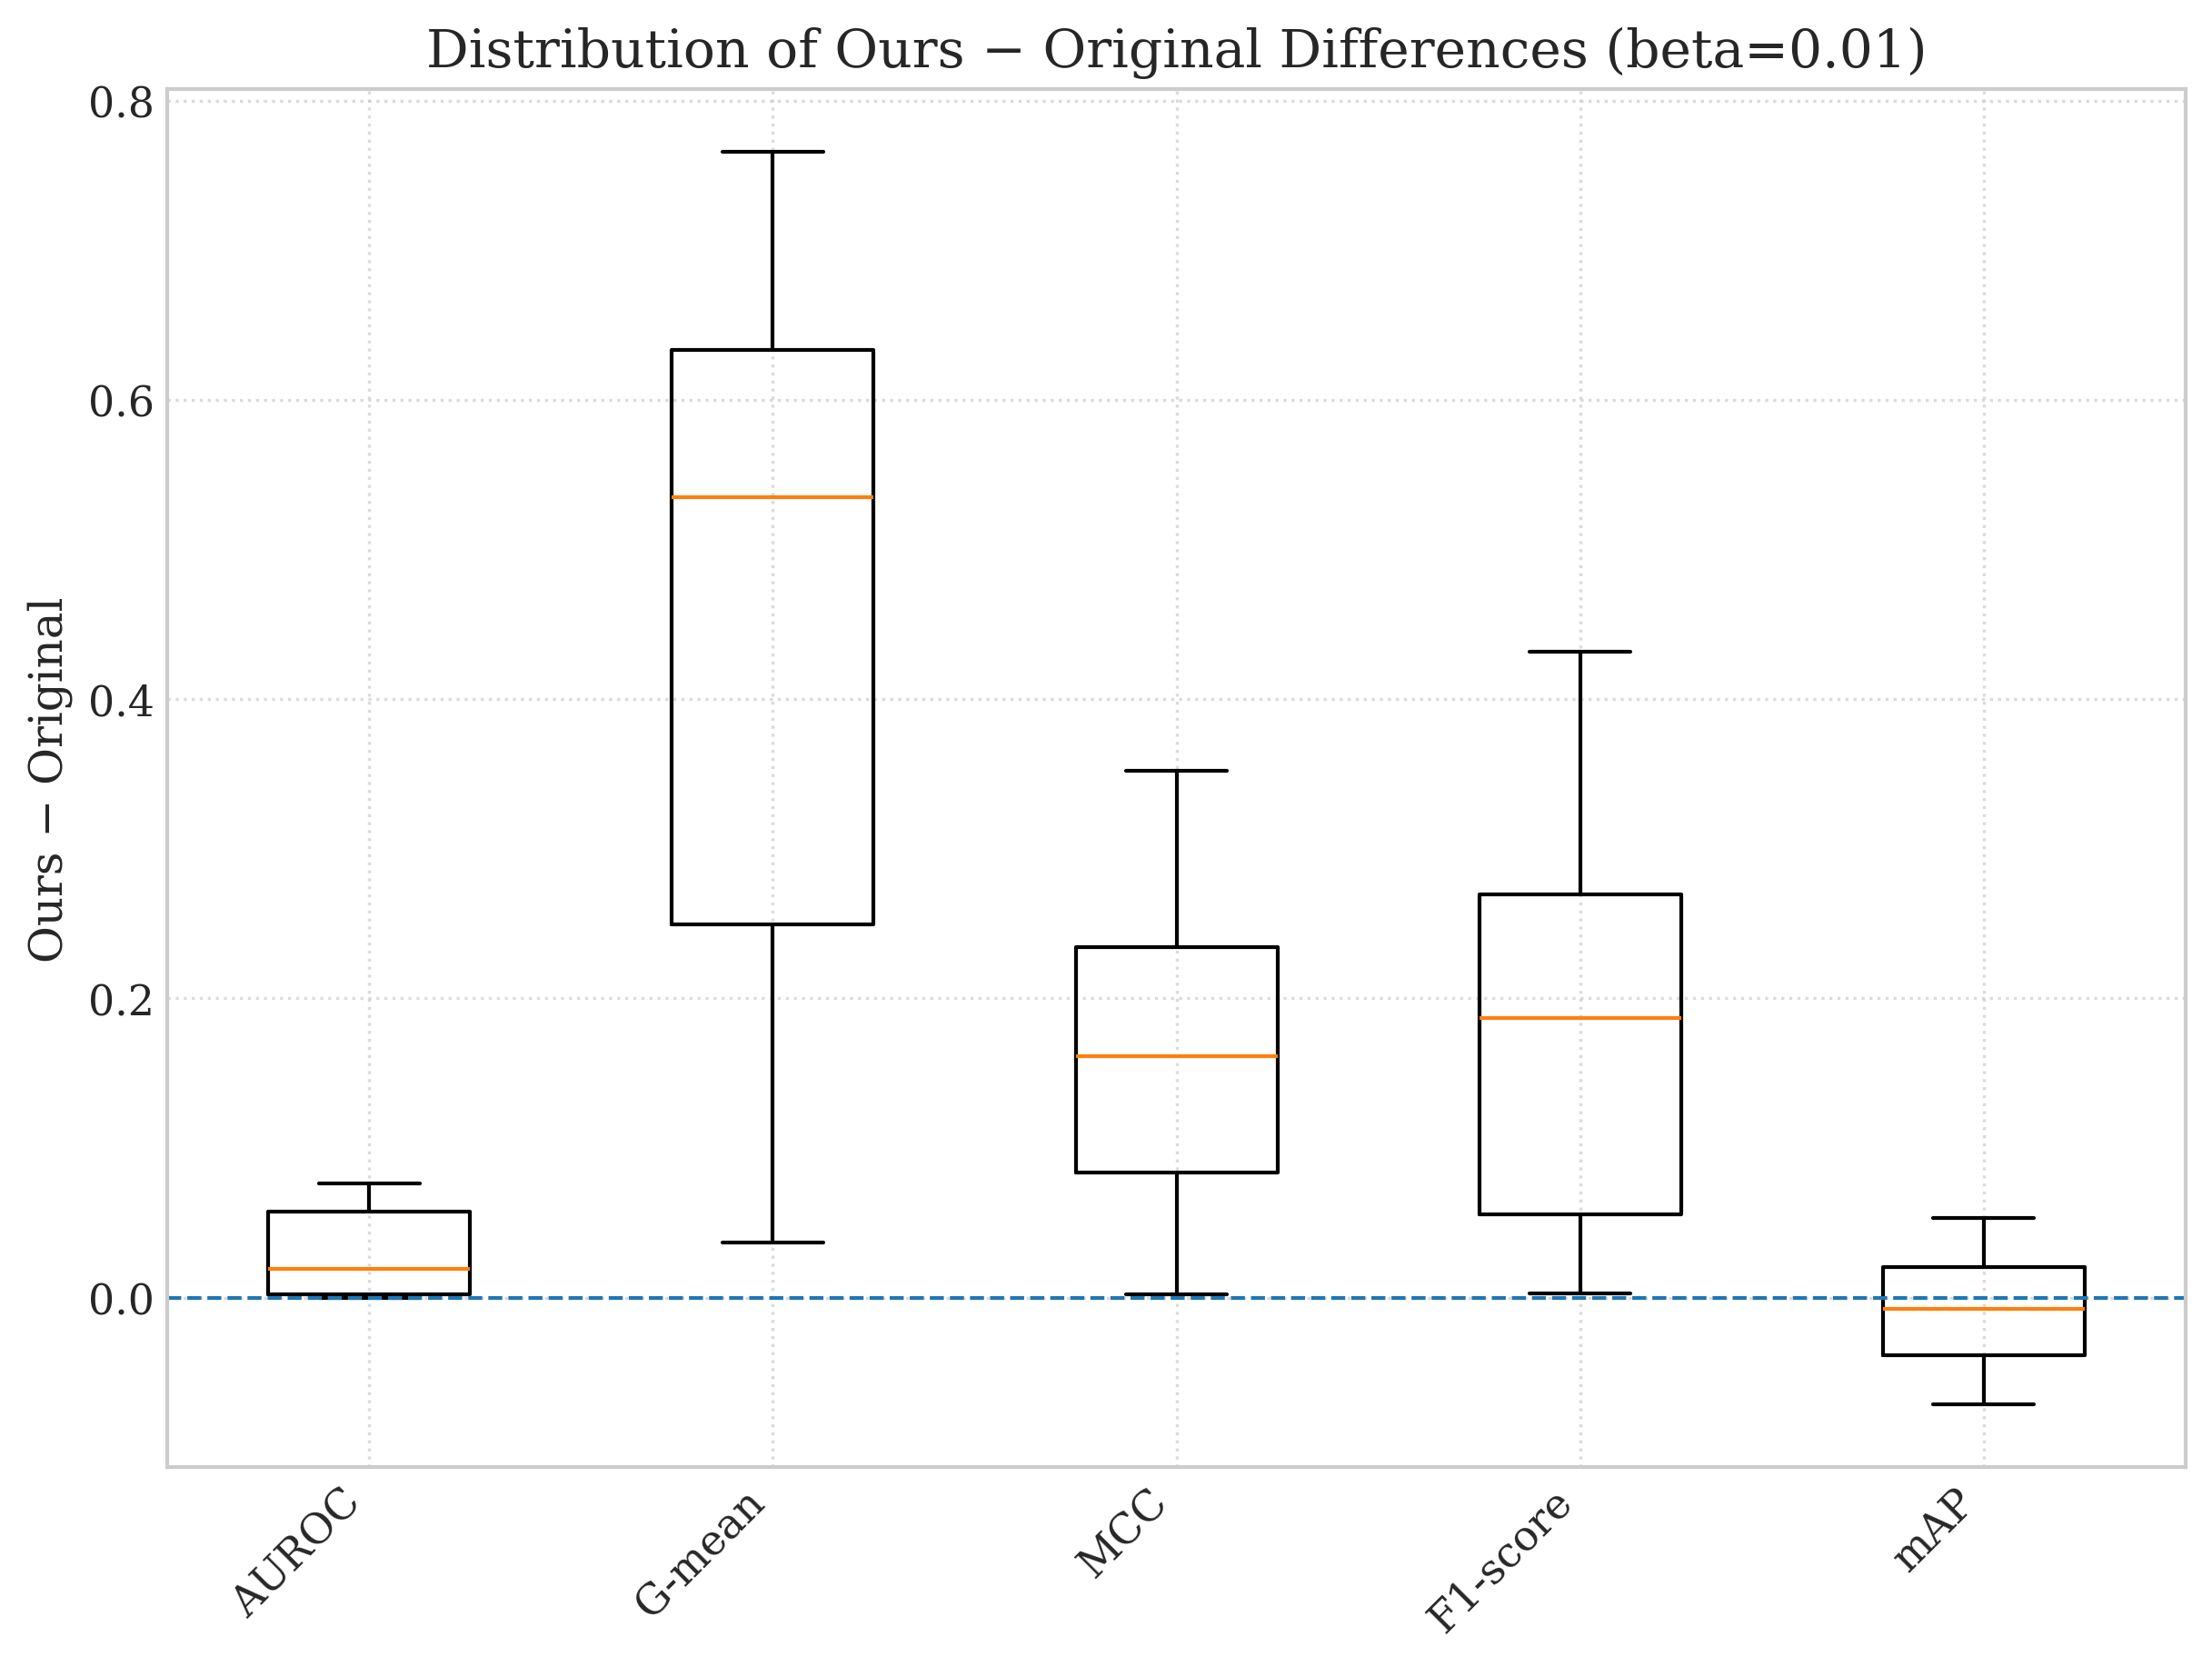

In [49]:
beta_fixed = BETA1  # or any other beta value you want to analyze
diffs, labels = [], []
for metric, df in df_numeric_by_beta_metric[beta_fixed].items():
    if {'Original','Ours'}.issubset(df.columns):
        arr = (
            df[['Original','Ours']]
            .drop(index=[COUNT_ROW, AVG_ROW], errors='ignore')
            .dropna()
        )
        diffs.append((arr['Ours'] - arr['Original']).values)
        labels.append(metric)

fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
ax.boxplot(diffs, whis=[5,95], showfliers=False)
ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=11)
ax.axhline(0, linestyle='--', linewidth=1)
ax.set_ylabel('Ours − Original', fontsize=12)
ax.set_title(f'Distribution of Ours − Original Differences (beta={beta_fixed})', fontsize=14)
ax.grid(True, linestyle=':', linewidth=0.8, alpha=0.7)
plt.show()


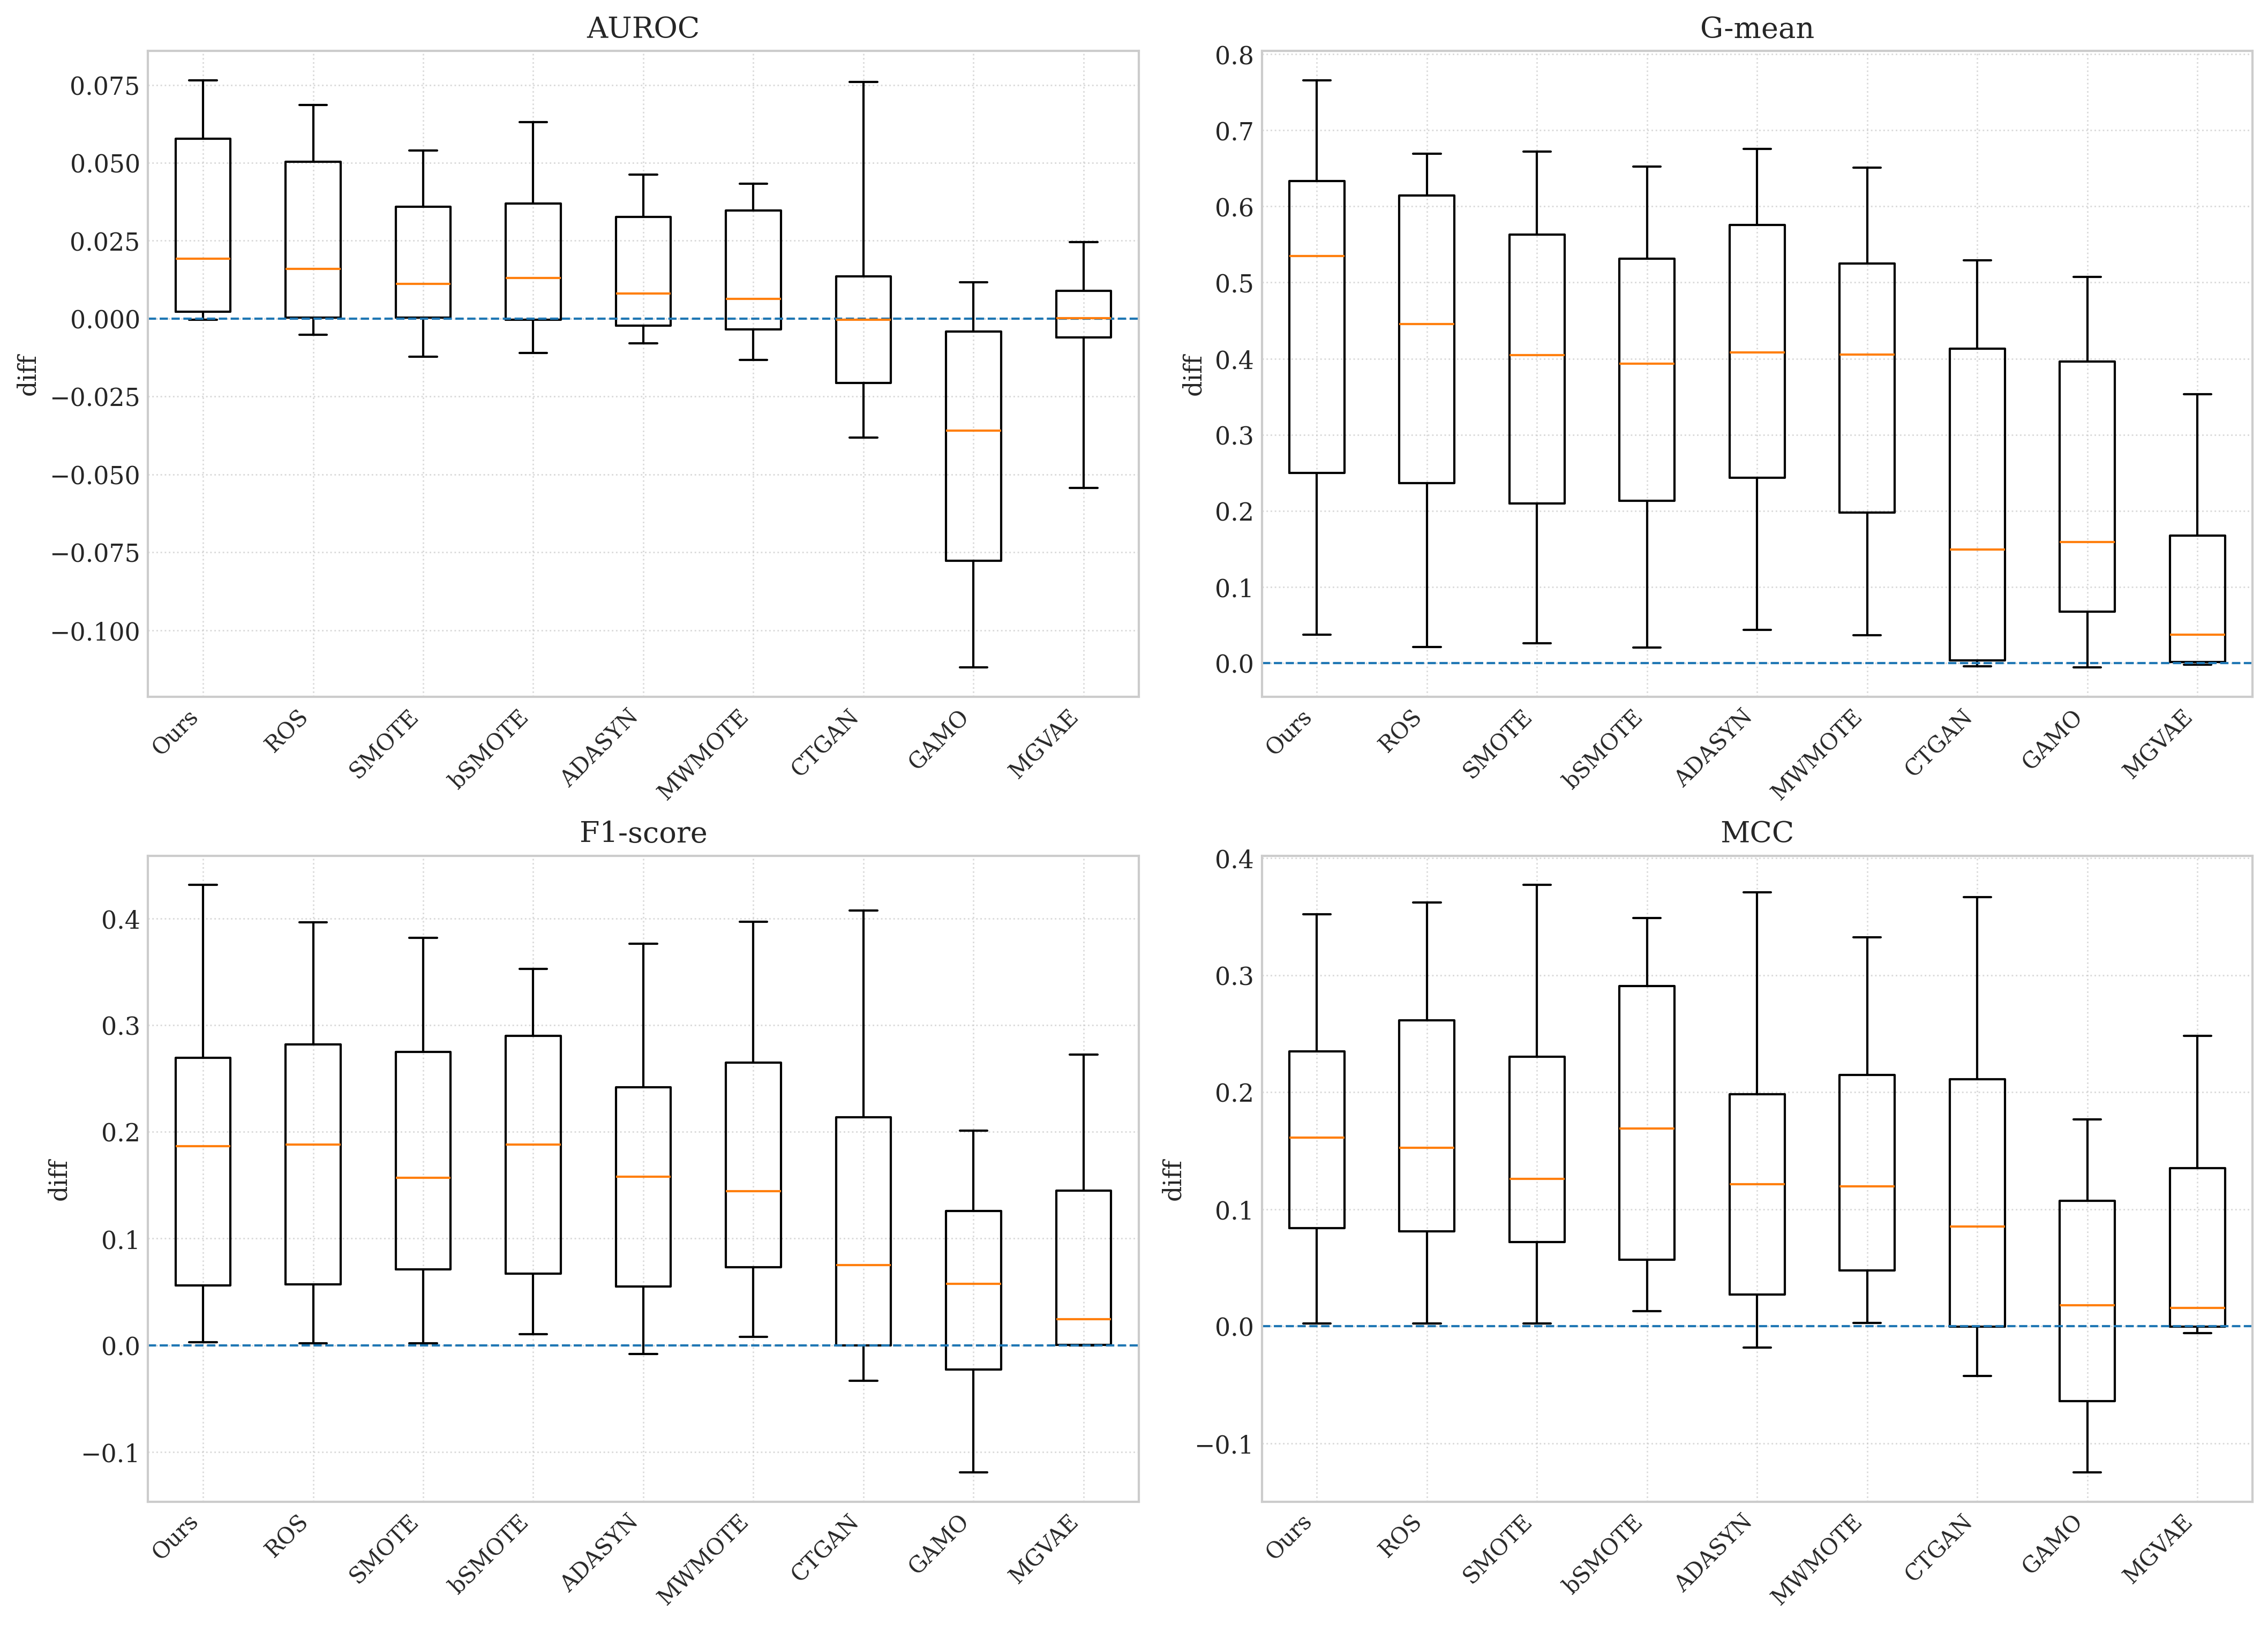

In [50]:
methods_to_compare = ['Ours', 'ROS', 'SMOTE', 'bSMOTE', 'ADASYN', 'MWMOTE', 'CTGAN', 'GAMO', 'MGVAE']
metrics_to_plot = ['AUROC', 'G-mean', 'F1-score', 'MCC']

fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    df = df_numeric_by_beta_metric[beta_fixed].get(metric)
    if df is None or 'Original' not in df.columns:
        continue

    diffs = []
    labels = []

    for method in methods_to_compare:
        if method in df.columns:
            arr = (
                df[['Original', method]]
                .drop(index=[COUNT_ROW, AVG_ROW], errors='ignore')
                .dropna()
            )
            diffs.append((arr[method] - arr['Original']).values)
            labels.append(method)

    if diffs:
        ax.boxplot(diffs, whis=[5, 95], showfliers=False)
        ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=10)
        ax.axhline(0, linestyle='--', linewidth=1)
        ax.set_title(f"{metric}", fontsize=13)
        ax.set_ylabel('diff', fontsize=11)
        ax.grid(True, linestyle=':', linewidth=0.7, alpha=0.7)

# PDF로 저장
plt.savefig("metric_diff_boxplot.pdf", format="pdf")

# 시각화 출력
plt.show()

In [ ]:
import os 
import glob

valid_names = set(cleaned_df_by_beta_metric[beta_fixed]['AUROC'].index)

# 데이터가 저장된 디렉토리
data_dir = "/data4/oldrain123/oldrain123/results/ablation_results/beta8"
pattern = os.path.join(data_dir, "*_results_gaussian_beta_*.csv")
files = glob.glob(pattern)

In [ ]:
all_data = []
for file in files:
    basename = os.path.basename(file)
    try:
        data_name, beta_part = basename.split("_results_gaussian_beta_", 1)
    except ValueError:
        continue  

    # # 3) data_name이 유효한지 확인
    # if data_name not in valid_names:
    #     continue

    # 4) beta 값 파싱
    beta_str = beta_part.replace(".csv", "")
    beta_value = float(beta_str)

    # 5) CSV 읽고 beta 컬럼 추가
    df = pd.read_csv(file)
    df["beta"] = beta_value

    all_data.append(df)

In [ ]:
combined_df = pd.concat(all_data, ignore_index=True)

In [ ]:
combined_df.groupby("Classifier")['beta'].value_counts().sort_index()['SVM']

In [ ]:
grouped = combined_df.groupby(["Classifier", "Metric", "beta"])["Value"].mean().reset_index()

In [ ]:
import ace_tools_open as tools

tools.display_dataframe_to_user(name = 'grouped', dataframe=grouped)

In [ ]:
classifiers = grouped["Classifier"].unique()
metrics = grouped["Metric"].unique()

fig, axs = plt.subplots(len(classifiers), 1, figsize=(12, 8 * len(classifiers)), sharex=True)

if len(classifiers) == 1:
    axs = [axs]

for i, clf in enumerate(classifiers):
    ax = axs[i]
    sub_df = grouped[grouped["Classifier"] == clf]

    for metric in metrics:
        metric_df = sub_df[sub_df["Metric"] == metric]
        ax.plot(metric_df["beta"], metric_df["Value"], label=metric, marker="o")
        
        # 최고 성능 beta 위치에 마커 추가
        max_idx = metric_df["Value"].idxmax()
        max_row = metric_df.loc[max_idx]
        ax.plot(max_row["beta"], max_row["Value"], marker="*", markersize=12, label=f"{metric} max", linestyle="None")

    ax.set_title(f"{clf}")
    ax.set_xlabel("Beta")
    ax.set_ylabel("Metric Value")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# beta별 metric 평균값 계산 (각 classifier에 대해)
avg_df = grouped.groupby(["Classifier", "beta"])["Value"].median().reset_index()

# 시각화
fig, axs = plt.subplots(len(classifiers), 1, figsize=(12, 5 * len(classifiers)), sharex=True)

if len(classifiers) == 1:
    axs = [axs]

for i, clf in enumerate(classifiers):
    ax = axs[i]
    clf_df = avg_df[avg_df["Classifier"] == clf]
    
    ax.plot(clf_df["beta"], clf_df["Value"], label="Avg Metric", marker="o", color="black")
    
    # 최고 평균 성능 beta 위치에 마커 추가
    max_idx = clf_df["Value"].idxmax()
    max_row = clf_df.loc[max_idx]
    ax.plot(max_row["beta"], max_row["Value"], marker="*", markersize=14, color="gold", label="Best Avg Beta", linestyle="None")

    ax.set_title(f"{clf} - Average of Metrics")
    ax.set_xlabel("Beta")
    ax.set_ylabel("Average Metric Value")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# beta=0.0 데이터가 있는 디렉토리를 추가로 읽어서 병합
dir_beta5 = "/data4/oldrain123/oldrain123/results/ablation_results/beta5"
pattern_beta8 = os.path.join("/data4/oldrain123/oldrain123/results/ablation_results/beta8", "*_results_gaussian_beta_*.csv")
pattern_beta5 = os.path.join(dir_beta5, "*_results_gaussian_beta_0.0.csv")

# 두 디렉토리의 파일을 모두 수집
files = glob.glob(pattern_beta8) + glob.glob(pattern_beta5)

all_data = []
for file in files:
    basename = os.path.basename(file)
    beta_str = basename.split('_results_gaussian_beta_')[1].replace('.csv', '')
    beta_value = float(beta_str)

    df = pd.read_csv(file)
    df["beta"] = beta_value
    all_data.append(df)

# 데이터 병합 및 요약
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    grouped = combined_df.groupby(["Classifier", "Metric", "beta"])["Value"].mean().reset_index()

    # beta별 metric 평균값 계산 (각 classifier에 대해)
    avg_df = grouped.groupby(["Classifier", "beta"])["Value"].mean().reset_index()
    classifiers = avg_df["Classifier"].unique()

    # 시각화
    fig, axs = plt.subplots(len(classifiers), 1, figsize=(12, 5 * len(classifiers)), sharex=True)

    if len(classifiers) == 1:
        axs = [axs]

    for i, clf in enumerate(classifiers):
        ax = axs[i]
        clf_df = avg_df[avg_df["Classifier"] == clf]

        ax.plot(clf_df["beta"], clf_df["Value"], label="Avg Metric", marker="o", color="black")

        # 최고 평균 성능 beta 위치에 마커 추가
        max_idx = clf_df["Value"].idxmax()
        max_row = clf_df.loc[max_idx]
        ax.plot(max_row["beta"], max_row["Value"], marker="*", markersize=14, color="gold", label="Best Avg Beta", linestyle="None")

        ax.set_title(f"{clf} - Average of Metrics")
        ax.set_xlabel("Beta")
        ax.set_ylabel("Average Metric Value")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("No CSV files were found in the specified directories.")

In [ ]:
if all_data:
    combined_df = pd.concat(all_data, ignore_index=True)
    grouped = combined_df.groupby(["Classifier", "Metric", "beta"])["Value"].median().reset_index()

    classifiers = grouped["Classifier"].unique()
    metrics = grouped["Metric"].unique()

    fig, axs = plt.subplots(len(classifiers), 1, figsize=(12, 8 * len(classifiers)), sharex=True)

    if len(classifiers) == 1:
        axs = [axs]

    for i, clf in enumerate(classifiers):
        ax = axs[i]
        sub_df = grouped[grouped["Classifier"] == clf]

        for metric in metrics:
            metric_df = sub_df[sub_df["Metric"] == metric]
            ax.plot(metric_df["beta"], metric_df["Value"], label=metric, marker="o")

            # 최고 성능 beta 위치에 마커 추가
            max_idx = metric_df["Value"].idxmax()
            max_row = metric_df.loc[max_idx]
            ax.plot(max_row["beta"], max_row["Value"], marker="*", markersize=12, label=f"{metric} max", linestyle="None")

        ax.set_title(f"{clf}")
        ax.set_xlabel("Beta")
        ax.set_ylabel("Metric Value")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("No CSV files were found in the specified directories.")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# grouped: DataFrame with columns [Classifier, Metric, beta, Value] from your code
# 1) 베이스라인 값(β=0) 추출
baseline = (
    grouped[grouped['beta'] == 0.0]
    .set_index(['Classifier','Metric'])['Value']
    .rename('baseline')
)

# 2) 원본에 baseline 합치고 delta 계산
df2 = (
    grouped
    .set_index(['Classifier','Metric'])
    .join(baseline, on=['Classifier','Metric'])
    .reset_index()
)
df2['delta'] = df2['Value'] - df2['baseline']

# 3) delta 시각화
classifiers = df2['Classifier'].unique()
metrics     = df2['Metric'].unique()

fig, axs = plt.subplots(len(classifiers), 1, figsize=(10, 4*len(classifiers)), sharex=True)

if len(classifiers)==1: axs=[axs]

for i, clf in enumerate(classifiers):
    ax = axs[i]
    sub = df2[df2['Classifier']==clf]
    for metric in metrics:
        mdf = sub[sub['Metric']==metric]
        ax.plot(mdf['beta'], mdf['delta'], marker='o', label=metric)
    ax.set_xscale('log')
    ax.set_ylabel('Δ Value vs β=0')
    ax.set_title(f'{clf} — Absolute Δ')
    ax.grid(True)
    ax.legend()

axs[-1].set_xlabel('Beta')
plt.tight_layout()
plt.show()

In [ ]:
# 1) rel_change 계산
df2['rel_pct'] = 100 * (df2['Value'] - df2['baseline']) / df2['baseline']

# 2) rel_pct 시각화 (위와 동일 구조)
fig, axs = plt.subplots(len(classifiers), 1, figsize=(10, 4*len(classifiers)), sharex=True)
if len(classifiers)==1: axs=[axs]

for i, clf in enumerate(classifiers):
    ax = axs[i]
    sub = df2[df2['Classifier']==clf]
    for metric in metrics:
        mdf = sub[sub['Metric']==metric]
        ax.plot(mdf['beta'], mdf['rel_pct'], marker='^', label=metric)
    ax.set_xscale('log')
    ax.set_ylabel('Relative % Change')
    ax.set_title(f'{clf} — % Change vs β=0')
    ax.grid(True)
    ax.legend()

axs[-1].set_xlabel('Beta')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) β 리스트 (원본 순서 유지)
betas = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1]
beta_pos = {b: i for i, b in enumerate(betas)}

# 2) Classifier, Metric 리스트 
classifiers = grouped["Classifier"].unique()
metrics = ["AUROC", "G-mean", "mAP", "F1-score"]

# 3) 그리드: 행=Classifier, 열=Metric
n_rows, n_cols = len(classifiers), len(metrics)
fig, axs = plt.subplots(
    n_rows, n_cols,
    figsize=(4 * n_cols, 3.5 * n_rows),
    sharex=False, sharey=False,
    constrained_layout=True
)

# 4) 반복 그리기
for i, clf in enumerate(classifiers):
    for j, metric in enumerate(metrics):
        ax = axs[i, j] if n_rows > 1 else axs[j]
        sub = grouped[(grouped["Classifier"] == clf) & (grouped["Metric"] == metric)]
        x = [beta_pos[b] for b in sub["beta"]]
        y = sub["Value"].values

        # 성능 곡선
        ax.plot(x, y, marker="o", linestyle="-", linewidth=1.5)

        # 최고점 ★ 강조 및 annotation
        idx_max = np.argmax(y)
        ax.scatter(x[idx_max], y[idx_max], marker="*", s=120, color="C1")
        ax.annotate(
            f"{betas[idx_max]}",
            (x[idx_max], y[idx_max]),
            textcoords="offset points", xytext=(0, 8),
            ha="center", fontsize=9
        )

        # 축 제목, 그리드
        if i == 0:
            ax.set_title(metric, fontsize=12)
        if i == n_rows - 1:
            ax.set_xticks(list(beta_pos.values()))
            ax.set_xticklabels([str(b) for b in betas], rotation=30, ha="right", fontsize=9)
            ax.set_xlabel("Beta", fontsize=10)
        if j == 0:
            ax.set_ylabel(clf, fontsize=10)

        ax.grid(True, linestyle="--", alpha=0.4)

# 5) 전체 타이틀
fig.suptitle("Beta Coefficient vs Performance (per Classifier × Metric)", fontsize=14)
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) β 리스트 (원본 순서 유지)
betas = [0.0, 0.001, 0.005, 0.01, 0.05, 0.1]
beta_pos = {b: i for i, b in enumerate(betas)}

# 2) Classifier, Metric 리스트 (mAP 제외)
classifiers = grouped["Classifier"].unique()
metrics = ["AUROC", "G-mean", "mAP", "F1-score"]

# 3) classifier별로 별도 figure 생성, 4×1 subplots
for clf in classifiers:
    fig, axs = plt.subplots(
        1,len(metrics),
        figsize=(8 * len(metrics), 8),
        sharex=True,
        constrained_layout=True
    )
    if len(metrics) == 1:
        axs = [axs]

    for ax, metric in zip(axs, metrics):
        # 해당 classifier & metric 데이터만 추출
        sub = grouped[
            (grouped["Classifier"] == clf) &
            (grouped["Metric"] == metric)
        ]

        # 4) β별 mean/std 계산
        stats = (
            sub
            .groupby("beta")["Value"]
            .agg(mean="mean", std="std")
            .reindex(betas)  # betas 순서 보장
            .reset_index()
        )

        x = [beta_pos[b] for b in stats["beta"]]
        mean = stats["mean"].values
        std  = stats["std"].fillna(0).values  # NaN일 경우 0으로 처리

        # 5) mean 선, std band
        ax.plot(x, mean, marker="o", linestyle="-", linewidth=1.5)
        ax.fill_between(x, mean - std, mean + std, alpha=0.2)

        # 6) 최고점 ★ 강조 및 annotation
        idx_max = np.nanargmax(mean)
        x_max, y_max = x[idx_max], mean[idx_max]
        ax.scatter(x_max, y_max, marker="*", s=120, color="C1")
        ax.annotate(
            f"{betas[idx_max]}",
            (x_max, y_max),
            textcoords="offset points",
            xytext=(0, 8),
            ha="center",
            fontsize=9
        )

        # 7) subplot 축/제목 설정
        ax.set_ylabel(metric, fontsize=11)
        ax.grid(True, linestyle="--", alpha=0.4)

    # 8) 마지막 subplot에만 x축 레이블 및 tick 설정
    axs[-1].set_xticks(list(beta_pos.values()))
    axs[-1].set_xticklabels([str(b) for b in betas], rotation=30, ha="right", fontsize=10)
    axs[-1].set_xlabel("Beta coefficient", fontsize=12)

    # 9) figure 제목으로 classifier 이름
    fig.suptitle(f"Classifier: {clf}", fontsize=14)
    plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare metric tables as DataFrames, with classifiers as rows and methods as columns
auroc_means = pd.DataFrame({
    'Original':     [0.7264, 0.8847, 0.7699, 0.5997],
    'ROS':          [0.7418, 0.8839, 0.7678, 0.8551],
    'SMOTE':        [0.7568, 0.8853, 0.8072, 0.8491],
    'bSMOTE':       [0.7439, 0.8850, 0.7982, 0.8443],
    'ADASYN':       [0.7599, 0.8836, 0.8063, 0.8494],
    'MWMOTE':       [0.7517, 0.8796, 0.7936, 0.8335],
    'CTGAN':        [0.7528, 0.8859, 0.7825, 0.8031],
    'GAMO':         [0.7558, 0.8739, 0.7694, 0.7777],
    'MGVAE':        [0.7451, 0.8851, 0.7801, 0.8206],
    'Ours':         [0.7824, 0.8923, 0.8080, 0.8538]
}, index=['DT', 'RF', 'kNN', 'MLP'])

gmean_means = pd.DataFrame({
    'Original':     [0.4975, 0.3948, 0.3778, 0.1837],
    'ROS':          [0.6421, 0.4670, 0.6235, 0.7167],
    'SMOTE':        [0.6663, 0.5369, 0.7086, 0.7074],
    'bSMOTE':       [0.6370, 0.5255, 0.6836, 0.6875],
    'ADASYN':       [0.6672, 0.5292, 0.7072, 0.7095],
    'MWMOTE':       [0.6386, 0.5044, 0.6629, 0.6758],
    'CTGAN':        [0.5004, 0.4828, 0.4753, 0.5219],
    'GAMO':         [0.5123, 0.4815, 0.4554, 0.5147],
    'MGVAE':        [0.5007, 0.3998, 0.4711, 0.5630],
    'Ours':         [0.6646, 0.5315, 0.7147, 0.7009]
}, index=['DT', 'RF', 'kNN', 'MLP'])

f1_means = pd.DataFrame({
    'Original':     [0.4003, 0.3504, 0.3238, 0.1540],
    'ROS':          [0.3944, 0.3931, 0.3996, 0.3841],
    'SMOTE':        [0.3970, 0.4302, 0.3935, 0.3851],
    'bSMOTE':       [0.4125, 0.4317, 0.4133, 0.3934],
    'ADASYN':       [0.3905, 0.4282, 0.3870, 0.3782],
    'MWMOTE':       [0.3961, 0.4092, 0.3885, 0.3739],
    'CTGAN':        [0.3974, 0.4088, 0.3576, 0.3298],
    'GAMO':         [0.3674, 0.4384, 0.3180, 0.3022],
    'MGVAE':        [0.4058, 0.3553, 0.3816, 0.3686],
    'Ours':         [0.4083, 0.4413, 0.3901, 0.3797]
}, index=['DT', 'RF', 'kNN', 'MLP'])

mcc_means = pd.DataFrame({
    'Original':     [0.3838, 0.3525, 0.3253, 0.1389],
    'ROS':          [0.3728, 0.3882, 0.3723, 0.3745],
    'SMOTE':        [0.3772, 0.4110, 0.3788, 0.3739],
    'bSMOTE':       [0.3881, 0.4159, 0.3928, 0.3772],
    'ADASYN':       [0.3706, 0.4081, 0.3724, 0.3678],
    'MWMOTE':       [0.3734, 0.3916, 0.3690, 0.3579],
    'CTGAN':        [0.3825, 0.4027, 0.3509, 0.3143],
    'GAMO':         [0.3522, 0.3780, 0.3042, 0.2774],
    'MGVAE':        [0.3903, 0.3563, 0.3719, 0.3496],
    'Ours':         [0.3949, 0.4337, 0.3747, 0.3704]
}, index=['DT', 'RF', 'kNN', 'MLP'])

In [ ]:
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "DejaVu Serif"], # Prioritize classic serif fonts
    "font.size": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 9,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 8,
    "mathtext.fontset": "dejavuserif", # Ensures mathematical text matches the serif style
})

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler

fig, axes = plt.subplots(2, 2, figsize=(16, 15))
methods = ['Original','ROS','SMOTE','bSMOTE','ADASYN','MWMOTE','CTGAN','GAMO','MGVAE','Ours']
# Mapping of metric names to (DataFrame, axis, y-axis limits)
metrics = {
    'AUROC':   (auroc_means,  axes[0, 0], (0.45, 0.95)),
    'G-mean':  (gmean_means,  axes[0, 1], (0.35, 0.8)),
    'F1-score':(f1_means,    axes[1, 0], (0.15, 0.45)),
    'MCC':     (mcc_means,   axes[1, 1], (0.15, 0.45))
}

professional_colors = sns.color_palette("muted", n_colors=len(methods))

for name, (df, ax, ylim) in metrics.items():
    df = df[methods]
    df.plot(
        kind='bar',
        ax=ax,
        color=professional_colors,
        edgecolor='black',
        linewidth=1,
        width=0.8,
        grid=False
    )

    ax.set_title(f'{name}', fontsize=16)
    ax.set_ylim(*ylim)
    ax.set_ylabel(name, fontsize=14)
    # Rotate x-tick labels for readability
    ax.tick_params(axis='x', labelsize=12, rotation=0, pad=2)
    ax.tick_params(axis='y', labelsize=12)
    ax.get_legend().remove()

# Shared legend above the panels
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='upper center',
    ncol=len(labels)//2,
    frameon=True,
    fontsize=14,
    bbox_to_anchor=(0.5, 1.02)
)

# Adjust layout and save
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('real_data_results.pdf', format='pdf', bbox_inches='tight')
fig.savefig('real_data_results.png', format='png', bbox_inches='tight', dpi=300)
plt.show()